### Importation lib

In [1]:
import pandas as pd
from math import *
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import dateutil.parser
import re
import contextualbandits
import time
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from scipy import stats as stats
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, make_scorer
import statsmodels.api as sm

pd.set_option('display.max_columns', 80)
pd.set_option('expand_frame_repr', True)

%matplotlib inline
sns.set_palette("hls")

import ipynb

# Traitement données

Importation des données et nettoyage :

In [2]:
path = '/home/agary/Documents/Data/npb_fast/02_remove_wm/'
filename = 'raw_data.csv'

df = pd.read_csv(path + filename)

In [3]:
df.head()

Unnamed: 0 name    duration  duration.1  duration.2  duration.3  duration.4  \
0       fmax  NaN  1200000.00  1300000.00  1400000.00  1500000.00  1600000.00   
1          0   lu       28.63       26.72       24.89       23.76       22.97   
2          1   is       15.86       15.28       15.08       14.60       14.32   
3          2   ft       11.73       10.95       10.57       10.12        9.61   
4          3   is       15.86       15.53       15.11       14.65       14.17   

   duration.5  duration.6  duration.7  duration.8  duration.9  duration.10  \
0  1700000.00  1800000.00  1900000.00  2000000.00  2100000.00   2200000.00   
1       21.44       20.50       19.75       18.98       18.28        17.61   
2       14.03       13.73       13.40       13.14       12.91        12.67   
3        9.29        9.14        8.75        8.46        8.22         8.00   
4       13.98       13.79       13.37       13.13       12.96        12.77   

   duration.11  duration.12  ref_energy  ref_energy.1  ref_energy.2  \
0   2300000.00   2400000.00  1200000.00    1300000.00    1400000.00   
1        17.05        16.24     4638.06       4382.08       4131.74   
2        12.28        12.01     2394.86       2330.20       2337.40   
3         7.81         7.52     1865.07       1773.90       1754.62   
4        12.47        12.17     2339.35       2360.56       2342.05   

   ref_energy.3  ref_energy.4  ref_energy.5  ref_energy.6  ref_energy.7  \
0   1500000.000   1600000.000    1700000.00   1800000.000    1900000.00   
1      4039.200      3973.810       3859.20      3792.500       3732.75   
2      2277.600      2319.840       2371.07      2375.290       2331.60   
3      1674.860      1648.115       1579.30      1572.080       1601.25   
4      2248.775      2217.605       2236.80      2282.245       2246.16   

   ref_energy.8  ref_energy.9  ref_energy.10  ref_energy.11  ref_energy.12  
0    2000000.00    2100000.00    2200000.000    2300000.000     2400000.00  
1       3625.18       3564.60       3522.000       3461.150        3402.28  
2       2319.21       2336.71       2274.265       2320.920        2305.92  
3       1582.02       1360.41       1568.000       1374.560        1436.32  
4       2271.49       2293.92       2285.830       2250.835        2239.28

In [4]:
data = df.drop(labels=0,axis=0)
data = data.drop(columns=['Unnamed: 0'])

In [5]:
data.head()

name  duration  duration.1  duration.2  duration.3  duration.4  duration.5  \
1   lu     28.63       26.72       24.89       23.76       22.97       21.44   
2   is     15.86       15.28       15.08       14.60       14.32       14.03   
3   ft     11.73       10.95       10.57       10.12        9.61        9.29   
4   is     15.86       15.53       15.11       14.65       14.17       13.98   
5   sp     27.80       26.28       25.00       23.83       22.91       22.17   

   duration.6  duration.7  duration.8  duration.9  duration.10  duration.11  \
1       20.50       19.75       18.98       18.28        17.61        17.05   
2       13.73       13.40       13.14       12.91        12.67        12.28   
3        9.14        8.75        8.46        8.22         8.00         7.81   
4       13.79       13.37       13.13       12.96        12.77        12.47   
5       21.51       20.98       20.46       20.07        19.54        19.14   

   duration.12  ref_energy  ref_energy.1  ref_energy.2  ref_energy.3  \
1        16.24     4638.06       4382.08       4131.74      4039.200   
2        12.01     2394.86       2330.20       2337.40      2277.600   
3         7.52     1865.07       1773.90       1754.62      1674.860   
4        12.17     2339.35       2360.56       2342.05      2248.775   
5        18.88     5309.80       5177.16       5075.00      4908.980   

   ref_energy.4  ref_energy.5  ref_energy.6  ref_energy.7  ref_energy.8  \
1      3973.810       3859.20      3792.500       3732.75       3625.18   
2      2319.840       2371.07      2375.290       2331.60       2319.21   
3      1648.115       1579.30      1572.080       1601.25       1582.02   
4      2217.605       2236.80      2282.245       2246.16       2271.49   
5      4811.100       4788.72      4732.200       4657.56       4644.42   

   ref_energy.9  ref_energy.10  ref_energy.11  ref_energy.12  
1       3564.60       3522.000       3461.150        3402.28  
2       2336.71       2274.265       2320.920        2305.92  
3       1360.41       1568.000       1374.560        1436.32  
4       2293.92       2285.830       2250.835        2239.28  
5       4636.17       4572.360       4564.890        4568.96

Création du dataframe dt : contexte servant à l'algorithme LINUCB.

In [6]:
dt = pd.get_dummies(data['name'])

In [7]:
dt['duration'] = data['duration']

In [8]:
dt.head()

bt  cg  ep  ft  is  lu  mg  sp  duration
1   0   0   0   0   0   1   0   0     28.63
2   0   0   0   0   1   0   0   0     15.86
3   0   0   0   1   0   0   0   0     11.73
4   0   0   0   0   1   0   0   0     15.86
5   0   0   0   0   0   0   0   1     27.80

Création du dataframe de récompenses rewards, avec multiplication par -1.

In [9]:
rewards = (-1)*data[data.columns[14:27]]

rewards.head()

ref_energy  ref_energy.1  ref_energy.2  ref_energy.3  ref_energy.4  \
1    -4638.06      -4382.08      -4131.74     -4039.200     -3973.810   
2    -2394.86      -2330.20      -2337.40     -2277.600     -2319.840   
3    -1865.07      -1773.90      -1754.62     -1674.860     -1648.115   
4    -2339.35      -2360.56      -2342.05     -2248.775     -2217.605   
5    -5309.80      -5177.16      -5075.00     -4908.980     -4811.100   

   ref_energy.5  ref_energy.6  ref_energy.7  ref_energy.8  ref_energy.9  \
1      -3859.20     -3792.500      -3732.75      -3625.18      -3564.60   
2      -2371.07     -2375.290      -2331.60      -2319.21      -2336.71   
3      -1579.30     -1572.080      -1601.25      -1582.02      -1360.41   
4      -2236.80     -2282.245      -2246.16      -2271.49      -2293.92   
5      -4788.72     -4732.200      -4657.56      -4644.42      -4636.17   

   ref_energy.10  ref_energy.11  ref_energy.12  
1      -3522.000      -3461.150       -3402.28  
2      -2274.265      -2320.920       -2305.92  
3      -1568.000      -1374.560       -1436.32  
4      -2285.830      -2250.835       -2239.28  
5      -4572.360      -4564.890       -4568.96

# Fonctions

## LINUCB

#### DataControlK :

Control arm and data for bandit Check if a dataframe gets an equal number of colonms than K possible arms. Check if K geq 2. Print a message and stop if this two conditions are not respected. Else return TRUE.



Arguments :

- visitor_reward : Dataframe of integer or numeric values

- K : Integer value (optional)



Value :

- Logical value

In [10]:
def DataControlK(visitor_reward, K): # par defaut : K = np.shape(visitor_reward)[1] 
    if K < 2 :
        raise ValueError("Number of arm must be superior or equal to 2")

    
    if np.shape(visitor_reward)[1] != K :
        raise ValueError("Each arm need a result")

#### DataControlContextReward :

Control if number of item in data reward and context data are equal Print a message and stop if this condition is not respected. Else return TRUE.



Arguments :

- dt : Dataframe of integer numeric or factor values

- visitor_reward : Dataframe of integer or numeric values



Value :

- Logical Value

In [11]:
def DataControlContextReward(dt, visitor_reward):
    
    # Match size control
    if(np.shape(dt)[0] != np.shape(visitor_reward)[0]):
        raise ValueError("Number of rows in contextual data and reward data are not equal")

#### ReturnRealTheta :

Return real theta from a rigide regression of context to arm's reward. Return coefficients of regression (except intercept)



Arguments : 

- dt : Dataframe of context

- visitor_reward : Dataframe of integer or numeric values

- option : Option linear by default



Value :

- theta : theorical mean of each arm

In [12]:
## Problème avec ce code : ne renvoie pas ce qu'il faudrait pour la régression linéaire.
## Pas gênant pour la suite, mais il faudrait corriger.

def ReturnRealTheta(dt, visitor_reward, option = 'linear'):
    
    K = np.shape(visitor_reward)[1]
    n_f = np.shape(dt)[1]
    theta = []
    
    temp = pd.DataFrame.copy(dt)
    if option == 'linear' :
        for i in range(K):
            pred = visitor_reward[:,i]
            reg = sm.OLS(endog = pred,exog = temp).fit() #Resutats differents par rapport a la regression en R
            theta.append(reg.params)
            
            
    # A faire : regression log
    
    else :
        raise ValueError("Regression non lineaire")
    
    return theta

#### LINUCB :

Control data in visitor_reward with BanditRewardControl Stop if something is wrong.

At each iteration :

- Calculates the arm probabilities according to a linear regression of context in dt dataframe

- Choose the arm with the maximum upper bound (with alpha parameter)

- Receives a reward in visitor_reward for the arm and associated iteration

- Updates the results matrix S.

Returns the calculation time. Review the estimated, actual coefficient for each arm. See also ReturnRealTheta.



Arguments : 


- dt : Dataframe of integer or numeric values

- visitor_reward : Dataframe of integer or numeric values

- alpha : Numeric value (optional)

- K	: Integer value (optional)

In [13]:
def LINUCB(dt, visitor_reward0, alpha = None, K = None, IsRewardAreBoolean = None):

    if alpha == None :
        alpha = 1
    if K == None :
        K = np.shape(visitor_reward0)[1]
    if IsRewardAreBoolean == None :
        IsRewardAreBoolean = False
    # control data :
    DataControlK(visitor_reward0,K)
    DataControlContextReward(dt, visitor_reward0)
    
    # Data Formating :
    visitor_reward = np.array(visitor_reward0)
    
    # ContextMatrix :
    D = np.array(dt)
    n = np.shape(dt)[0]
    n_f = np.shape(D)[1]
    
    # Keep the past choice for regression :
    choices = np.zeros(n)
    rewards = np.zeros(n)
    proba = np.zeros(n)
    
    # Parameters to modelize :
    theta_hat = np.zeros((K,n_f))
    theta_hat_colnames = dt.columns
    theta_hat_index = visitor_reward0.columns
    
    # Regression variable :
    b = np.zeros((K,n_f))
    A = np.zeros((K,n_f,n_f))
    
    # Tempory variable :
    p = np.zeros(K)
    
    # Time keeper :
    tic = time.time()
    
    #Initialization :
    for j in range(K):
        A[j,:,:] = np.eye(n_f)
    
    for i in range(K):
        x_i = np.array(D[i,:],dtype=float)
        x_i0 = np.reshape(x_i,(n_f,1))
        for j in range(K):
            A_inv = np.linalg.inv(A[j,:,:])
            theta_hat[j,:] = A_inv.dot(b[j,:])
            ta = np.transpose(x_i0).dot(A_inv).dot(x_i0)
            a_upper_ci = alpha * sqrt(ta)
            a_mean = theta_hat[j,:].dot(x_i)
            p[j] = a_mean + a_upper_ci
        
        # Choose the highest :
        choices[i] = i

        # save probability :
        proba[i] = p[i]
        
        # see what kind of result we get :
        rewards[i] = visitor_reward[i,int(choices[i])]
        
        # update the input vector :
        x_it = np.transpose(x_i0)
        A[int(choices[i]),:,:] = A[int(choices[i]),:,:] + x_i0.dot(x_it)
        b[int(choices[i])] = b[int(choices[i])] + x_i*rewards[i]
    

    for i in range(K,n):
        x_i = np.array(D[i,:],dtype = float)
        x_i0 = np.reshape(x_i,(n_f,1))
        for j in range(K):
            A_inv = np.linalg.inv(A[j,:,:])
            theta_hat[j,:] = A_inv.dot(b[j,:])
            ta = np.transpose(x_i0).dot(A_inv).dot(x_i)
            a_upper_ci = alpha * sqrt(ta)
            a_mean = theta_hat[j,:].dot(x_i)
            p[j] = a_mean + a_upper_ci
            
        # choose the highest :
        choices[i] = np.argmax(p)
        
        # save probability :
        proba[i] = max(p)
        
        # see what kind of result we get :
        rewards[i] = visitor_reward[i,int(choices[i])]
        
        # update the input vector :
        x_it = np.transpose(x_i0)
        A[int(choices[i]),:,:] = A[int(choices[i]),:,:] + x_i0.dot(x_it)
        b[int(choices[i])] = b[int(choices[i])] + x_i*rewards[i]
        

    tac = time.time()

    # return real theta from a rigid regression :
    if IsRewardAreBoolean ==  False : 
        theta = ReturnRealTheta(dt=dt,visitor_reward=visitor_reward, option = 'linear')
    
    # return real theta from logit regression :
    if IsRewardAreBoolean ==  True : 
        theta = ReturnRealTheta(dt=dt,visitor_reward=visitor_reward, option = 'linear') 
    
    theta_hat = pd.DataFrame(theta_hat)
    theta_hat.columns = theta_hat_colnames
    theta_hat.index = theta_hat_index
    
    theta = pd.DataFrame(theta)
    theta.columns = theta_hat_colnames
    theta.index = theta_hat_index
    
    # return data, models, groups and results :
    return [proba, theta_hat, theta, choices, tac - tic]

#### Regret

See "cumulative_regret.ipynb"

In [14]:
def SimpleRegret(choice,visitor_reward):
    visitor_reward
    n = visitor_reward.shape[0]
    regret = np.zeros(n)
    for i in range(n):
        regret[i] = RegretValue(choice[i],np.array(visitor_reward)[i,:])
    return regret

def RegretValue(arm, vec_visitor_reward):
    return max(vec_visitor_reward) - vec_visitor_reward[int(arm)]

def cumulativeRegret(choice,visitor_reward):
    regret = SimpleRegret(choice,visitor_reward)
    return np.cumsum(regret)

#### Calcul meilleur bras

Fonction calculant le meilleur bras. Parcours les résultats approchés (Theta_hat) de LINUCB, et les mets en relation avec le dataframe de départ pour calculer la fréquence engendrant la plus basse consommation énergétique pour chaque application.

Pour chaque application : Calcule la consommation énergétique associée à chaque fréquence, les compare et sauvegarde la plus basse dans le dataframe "recap".

Calcule également la différence de consommation entre la fréquence optimale et les autres, et sauvegarde le gain moyen (moyenne des différences) dans le dataframe "recap".



Entrée : 

- data : dataframe

- res_linucb : dataframe



Sortie : 

- recap : dataframe

- temps_execution : valeur numérique

- consommations : array

In [15]:
def calcul_freq(data,res_linucb):

    liste_appli = ['bt','cg','ep','ft','is','lu','mg','sp']
    frequences = [1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2.0,2.1,2.2,2.3,2.4]
    
    temps_execution = []
    consommations = []
    best_consos = []
    
    best_freq = [] # On stocke la frequences optimale
    gains = [] # On stocke les gains moyens
    
    for k in range(len(liste_appli)) :
        app = liste_appli[k]
        print('Appli :', app)
        # Calcul des temps moyens :

        indices_app = np.where(data['name'] == app)[0] #On récupère les indices associés à l'application
        n = data.shape[0]
        temps = np.zeros(13)

        for i in range(n):
            if i in indices_app :
                for j in range(13):
                    temps[j] = temps[j] + float(data.iat[i,j+1])

        temps /= len(indices_app)
        temps_execution.append(temps)
        
        # Calcul de la consommation prévue
        
        consos = []
        for i in range(13):
            c = res_linucb.iat[i,k]
            d = res_linucb.iat[i,-1]
        

            energie = abs(c + temps[i]*d)
            consos.append(energie)
            print("Consommation pour " + str(frequences[i]) + " GHz :" + str(energie))
        print('')
        consommations.append(consos)
        indices_min = np.argmin(consos)
        best_consos.append(min(consos))

        best_freq.append(frequences[indices_min])
        
        # Construction du tableau recaptulatif :
        
        consos.remove(best_consos[-1])
        moy = np.mean(consos)

        if moy == 0 :
            gains.append('NA')
        else :
            gains.append(moy - best_consos[-1])
        
    a = np.array([best_freq, best_consos, gains])
    a = np.transpose(a)
    recap = pd.DataFrame(data=a, index=liste_appli, columns=['Frequence optimale', 'Consommation optimale', 'Gain moyen'])
    return [recap, temps_execution, consommations]

# Mise en oeuvre sur les données

### LINUCB sur les données telles quelles

Test de LINUCB sur les données importées en début de notebook.

In [16]:
linucb = LINUCB(dt,rewards)

In [17]:
linucb[1] #theta_hat -> Ok

bt          cg          ep          ft          is  \
ref_energy       0.000000    0.000000    0.000000    0.000000    0.000000   
ref_energy.1     0.000000    0.000000    0.000000    0.000000  507.490282   
ref_energy.2     0.000000  180.472471    0.000000  322.622631    0.000000   
ref_energy.3     0.000000  169.975323    0.000000    0.000000  577.556272   
ref_energy.4     0.000000    0.000000    0.000000    0.000000    0.000000   
ref_energy.5     0.000000  242.589958  374.489256  377.881212    0.000000   
ref_energy.6     0.000000  171.584259    0.000000    0.000000    0.000000   
ref_energy.7     0.000000    0.000000    0.000000    0.000000    0.000000   
ref_energy.8   867.558983 -140.193945  498.488031  238.442759  130.089318   
ref_energy.9     0.000000  236.413450    0.000000    0.000000    0.000000   
ref_energy.10    0.000000   68.285907    0.000000    0.000000  504.643810   
ref_energy.11    0.000000  -34.943656    0.000000    0.000000  229.933156   
ref_energy.12    0.000000    0.000000    0.000000    0.000000    0.000000   

                        lu           mg          sp    duration  
ref_energy      578.747727  -577.952808    0.000000 -202.429460  
ref_energy.1      0.000000  -295.386867    0.000000 -210.919329  
ref_energy.2      0.000000  -480.951296  306.096751 -204.592094  
ref_energy.3      0.000000  -595.847021  243.287447 -200.515186  
ref_energy.4      0.000000  -445.751978  454.239042 -205.740219  
ref_energy.5      0.000000  -595.459162  288.452650 -200.496425  
ref_energy.6      0.000000   -53.677946    0.000000 -220.696090  
ref_energy.7    861.728324  -844.975700    0.000000 -192.998833  
ref_energy.8    723.829788 -1960.904060 -448.317297 -154.386319  
ref_energy.9      0.000000  -518.352867  470.848627 -206.755312  
ref_energy.10     0.000000  -737.636131  454.190242 -196.370667  
ref_energy.11  1119.991090 -1236.602122    0.000000 -178.795480  
ref_energy.12     0.000000  -459.281658  490.393106 -207.764633

In [18]:
linucb[2] #theta theoriques -> A corriger

bt           cg          ep           ft           is  \
ref_energy      522.602883    29.896091  321.427448   239.756757   479.853652   
ref_energy.1  -4967.520928 -1003.849346 -662.708135 -1344.488708 -1759.309766   
ref_energy.2  -4490.996701  -934.397725 -566.581386 -1231.908912 -1649.085870   
ref_energy.3  -5139.158180 -1075.774505 -670.735054 -1430.384701 -1954.546035   
ref_energy.4  -4763.685689 -1025.204775 -592.862465 -1342.302909 -1863.852472   
ref_energy.5  -4859.187531 -1075.804450 -579.628957 -1388.431949 -1968.635108   
ref_energy.6  -4728.892197 -1118.525270 -551.787375 -1376.702212 -1984.761235   
ref_energy.7  -4368.612078 -1051.560455 -463.883923 -1264.967108 -1873.733276   
ref_energy.8  -3803.514041  -993.100589 -350.483394 -1100.705636 -1685.936804   
ref_energy.9  -4258.247209 -1089.894940 -409.350535 -1241.298509 -1906.605903   
ref_energy.10 -3947.111462 -1069.433976 -332.230367 -1147.297999 -1813.402541   
ref_energy.11 -4190.588752 -1126.765142 -375.099070 -1214.222088 -1930.989180   
ref_energy.12 -3640.084671 -1072.762804 -257.228776 -1045.002294 -1742.817328   

                        lu           mg           sp    duration  
ref_energy      491.443842 -1278.765066  -353.296205 -181.503708  
ref_energy.1  -3367.704153 -5338.335558 -4185.671787  -39.049219  
ref_energy.2  -3041.130439 -5159.954498 -3908.625521  -44.055947  
ref_energy.3  -3490.731504 -5766.284291 -4388.784244  -22.841120  
ref_energy.4  -3239.477754 -5645.694649 -4169.090098  -26.901041  
ref_energy.5  -3299.783886 -5861.599016 -4272.817999  -22.867091  
ref_energy.6  -3202.838586 -5890.597690 -4230.243473  -23.123563  
ref_energy.7  -2948.559426 -5756.166066 -3994.409490  -28.752218  
ref_energy.8  -2560.493299 -5478.164787 -3650.990920  -39.649759  
ref_energy.9  -2879.877752 -5916.271289 -3993.085452  -26.099493  
ref_energy.10 -2654.853550 -5796.777611 -3823.798859  -31.598151  
ref_energy.11 -2830.817850 -6078.460695 -4023.430015  -23.731795  
ref_energy.12 -2448.220489 -5788.757613 -3675.668376  -36.338489

In [19]:
linucb[3] #liste choix -> Ok

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        5., 11., 11., 11.,  8., 11.,  8.,  5.,  5.,  5.,  7.,  8.,  8.,
        8.,  8.,  8.,  8.,  3.,  3.,  8.,  8.,  8.,  1., 10.,  3.,  2.,
        9.,  8., 10.,  8., 10.,  8.,  8.,  8.,  9.,  2., 10.,  8.,  8.,
        8.,  8.,  8.,  0.,  8.,  8.,  8.,  5.,  8.,  8.,  8.,  9.,  5.,
        8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  5.,
        8.,  9.,  8.,  8.,  6.,  8.,  3.,  8.,  8.,  8.,  8.,  8.,  8.,
        9.,  8.,  8.,  3.,  9.,  8.,  5.,  8.,  8.,  8.,  8.,  8.,  2.,
        8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  2.,  8.,  8., 12.,  8.,
        5.,  4.,  2.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,
        8.,  8.,  8.,  5.,  8.,  8.,  8.,  5.,  8.,  8.,  8.,  8.,  8.,
        8.,  8.,  8.,  8., 11.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,
        8.,  8.,  1.,  8.,  8.,  8.,  8.,  8.,  8.,  7.,  8.,  3.,  8.,
        8.,  8.,  8.,  8.,  8.,  8.,  8.,  5.,  5.,  5.,  5.,  8

Tracé du regret cumulé à chaque itération

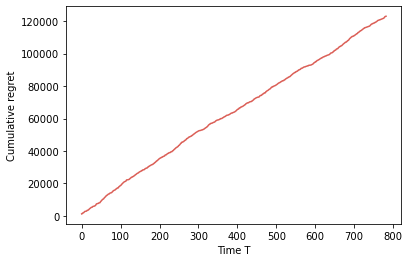

In [20]:
cum_reg = cumulativeRegret(linucb[3],rewards)
plt.plot(cum_reg);
plt.xlabel('Time T')
plt.ylabel('Cumulative regret');
plt.show();

Calcul de la fréquence optimale pour chaque application en se servant des résultats (theta_hat) de LINUCB :

In [21]:
recap, temps, conso = calcul_freq(data,linucb[1])

Appli : bt
Consommation pour 1.2 GHz :8256.470162190551
Consommation pour 1.3 GHz :8038.937135676477
Consommation pour 1.4 GHz :7330.002789690919
Consommation pour 1.5 GHz :6802.878717569117
Consommation pour 1.6 GHz :6627.880001712481
Consommation pour 1.7 GHz :6169.295054168644
Consommation pour 1.8 GHz :6515.522387808147
Consommation pour 1.9 GHz :5466.653345830264
Consommation pour 2.0 GHz :3331.6717128461487
Consommation pour 2.1 GHz :5413.412311950817
Consommation pour 2.2 GHz :4949.071003639904
Consommation pour 2.3 GHz :4333.483926442854
Consommation pour 2.4 GHz :4847.709851804947

Appli : cg
Consommation pour 1.2 GHz :1502.419062140174
Consommation pour 1.3 GHz :1500.669506074714
Consommation pour 1.4 GHz :1221.7766896988553
Consommation pour 1.5 GHz :1167.5018896347608
Consommation pour 1.6 GHz :1340.5444830065085
Consommation pour 1.7 GHz :1038.3776109364358
Consommation pour 1.8 GHz :1217.4048672309953
Consommation pour 1.9 GHz :1200.9647791717434
Consommation pour 2.0 GHz

Tableau récapitulatif des résultats :

In [22]:
recap

Frequence optimale  Consommation optimale   Gain moyen
bt                 2.0            3331.671713  2897.604678
cg                 2.1            1026.840410   204.548272
ep                 2.0             190.948250   843.054201
ft                 2.0            1074.902362   753.132021
is                 2.0            1897.548867   764.851028
lu                 2.3            1907.508985  2265.119612
mg                 2.4            5852.418687   181.052242
sp                 2.2            3411.396701   927.945845

### LINUCB après duplication et mélange des données

Second test de LINUCB : duplication et mélanges des données pour simuler un dataset plus important :

In [23]:
data2 = pd.concat([data,data], ignore_index=True)
for i in range(30):
    data2 = pd.concat([data2,data], ignore_index=True)
    
data2 = data2.sample(frac=1)

In [24]:
dt2 = pd.get_dummies(data2['name'])
dt2['duration'] = data2['duration']

rewards2 = (-1)*data2[data2.columns[14:27]]

In [25]:
res_linucb2 = LINUCB(dt2,rewards2)

In [26]:
print("Theta_hat")
print(res_linucb2[1])

Theta_hat
                        bt          cg          ep          ft          is  \
ref_energy        0.000000   68.628188  250.207543    0.000000  450.724336   
ref_energy.1    528.279092    0.000000    0.000000    0.000000    0.000000   
ref_energy.2      0.000000    0.000000    0.000000    0.000000    0.000000   
ref_energy.3      0.000000    0.000000    0.000000    0.000000    0.000000   
ref_energy.4      0.000000  -39.986145  164.408702    0.000000    0.000000   
ref_energy.5      0.000000    0.000000    0.000000    0.000000    0.000000   
ref_energy.6    792.552860   11.157020    0.000000    0.000000    0.000000   
ref_energy.7      0.000000  100.363807  806.819638  334.943134    0.000000   
ref_energy.8      0.000000   21.763450    0.000000    0.000000  289.364362   
ref_energy.9    986.503349 -104.093222    0.000000  177.355499  165.364590   
ref_energy.10     0.000000    0.000000    0.000000    0.000000  405.014617   
ref_energy.11  1192.816646  -99.499659    0.000000    

Tracé du regret cumulé à chaque itération :

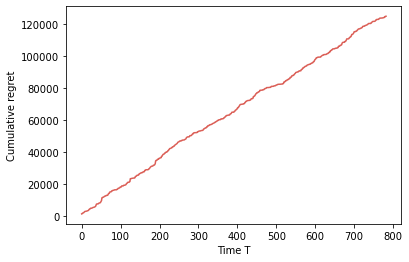

In [27]:
cum_reg = cumulativeRegret(res_linucb2[3],rewards)
plt.plot(cum_reg);
plt.xlabel('Time T')
plt.ylabel('Cumulative regret');
plt.show();

# Custom linucb :

Modification de LINUCB, avec remise à 0 des paramètres à un instant t :

In [32]:
def LINUCB_custom(dt, visitor_reward0, alpha=None, K=None, IsRewardAreBoolean=None,update=None):

    if alpha == None :
        alpha = 1
    if K == None :
        K = np.shape(visitor_reward0)[1]
    if IsRewardAreBoolean == None :
        IsRewardAreBoolean = False
    
    # control data :
    DataControlK(visitor_reward0,K)
    DataControlContextReward(dt, visitor_reward0)
    
    # Data Formating :
    visitor_reward = np.array(visitor_reward0)
    
    # ContextMatrix :
    D = np.array(dt)
    n = np.shape(dt)[0]
    n_f = np.shape(D)[1]
    
    if update==None :
        update = n//2
        
    # control update
    if update >= n-K :
        raise ValueError('Update value too high')
        
    # Keep the past choice for regression :
    choices = np.zeros(n)
    rewards = np.zeros(n)
    proba = np.zeros(n)
    
    # Parameters to modelize :
    theta_hat = np.zeros((K,n_f))
    theta_hat_colnames = dt.columns
    theta_hat_index = visitor_reward0.columns
    
    # Regression variable :
    b = np.zeros((K,n_f))
    A = np.zeros((K,n_f,n_f))
    
    # Tempory variable :
    p = np.zeros(K)
    
    # Time keeper :
    tic = time.time()
    
    
    #Initialization :
    for j in range(K):
        A[j,:,:] = np.eye(n_f)
    
    for i in range(K):
        x_i = np.array(D[i,:],dtype=float)
        x_i0 = np.reshape(x_i,(n_f,1))
        for j in range(K):
            A_inv = np.linalg.inv(A[j,:,:])
            theta_hat[j,:] = A_inv.dot(b[j,:])
            ta = np.transpose(x_i0).dot(A_inv).dot(x_i0)
            a_upper_ci = alpha * sqrt(ta)
            a_mean = theta_hat[j,:].dot(x_i)
            p[j] = a_mean + a_upper_ci
        
        # Choose the highest :
        choices[i] = i

        # save probability :
        proba[i] = p[i]
        
        # see what kind of result we get :
        rewards[i] = visitor_reward[i,int(choices[i])]
        
        # update the input vector :
        x_it = np.transpose(x_i0)
        A[int(choices[i]),:,:] = A[int(choices[i]),:,:] + x_i0.dot(x_it)
        b[int(choices[i])] = b[int(choices[i])] + x_i*rewards[i]
    

    for i in range(K,update):
        x_i = np.array(D[i,:],dtype = float)
        x_i0 = np.reshape(x_i,(n_f,1))
        for j in range(K):
            A_inv = np.linalg.inv(A[j,:,:])
            theta_hat[j,:] = A_inv.dot(b[j,:])
            ta = np.transpose(x_i0).dot(A_inv).dot(x_i)
            a_upper_ci = alpha * sqrt(ta)
            a_mean = theta_hat[j,:].dot(x_i)
            p[j] = a_mean + a_upper_ci
            
        # choose the highest :
        choices[i] = np.argmax(p)
        
        # save probability :
        proba[i] = max(p)
        
        # see what kind of result we get :
        rewards[i] = visitor_reward[i,int(choices[i])]
        
        # update the input vector :
        x_it = np.transpose(x_i0)
        A[int(choices[i]),:,:] = A[int(choices[i]),:,:] + x_i0.dot(x_it)
        b[int(choices[i])] = b[int(choices[i])] + x_i*rewards[i]
        
    
    ####### update #######
    
    # Regression variable :
    b = np.zeros((K,n_f))
    A = np.zeros((K,n_f,n_f))
    
    # Tempory variable :
    p = np.zeros(K)
    
    ######################
    
    #Initialization :
    for j in range(K):
        A[j,:,:] = np.eye(n_f)
    
    for i in range(K):
        x_i = np.array(D[i,:],dtype=float)
        x_i0 = np.reshape(x_i,(n_f,1))
        for j in range(K):
            A_inv = np.linalg.inv(A[j,:,:])
            theta_hat[j,:] = A_inv.dot(b[j,:])
            ta = np.transpose(x_i0).dot(A_inv).dot(x_i0)
            a_upper_ci = alpha * sqrt(ta)
            a_mean = theta_hat[j,:].dot(x_i)
            p[j] = a_mean + a_upper_ci
        
        # Choose the highest :
        choices[i] = i

        # save probability :
        proba[i] = p[i]
        
        # see what kind of result we get :
        rewards[i] = visitor_reward[i,int(choices[i])]
        
        # update the input vector :
        x_it = np.transpose(x_i0)
        A[int(choices[i]),:,:] = A[int(choices[i]),:,:] + x_i0.dot(x_it)
        b[int(choices[i])] = b[int(choices[i])] + x_i*rewards[i]
    

    for i in range(update+K,n):
        x_i = np.array(D[i,:],dtype = float)
        x_i0 = np.reshape(x_i,(n_f,1))
        for j in range(K):
            A_inv = np.linalg.inv(A[j,:,:])
            theta_hat[j,:] = A_inv.dot(b[j,:])
            ta = np.transpose(x_i0).dot(A_inv).dot(x_i)
            a_upper_ci = alpha * sqrt(ta)
            a_mean = theta_hat[j,:].dot(x_i)
            p[j] = a_mean + a_upper_ci
            
        # choose the highest :
        choices[i] = np.argmax(p)
        
        # save probability :
        proba[i] = max(p)
        
        # see what kind of result we get :
        rewards[i] = visitor_reward[i,int(choices[i])]
        
        # update the input vector :
        x_it = np.transpose(x_i0)
        A[int(choices[i]),:,:] = A[int(choices[i]),:,:] + x_i0.dot(x_it)
        b[int(choices[i])] = b[int(choices[i])] + x_i*rewards[i]
        
    
    tac = time.time()

    # return real theta from a rigid regression :
    if IsRewardAreBoolean ==  False : 
        theta = ReturnRealTheta(dt=dt,visitor_reward=visitor_reward, option = 'linear')
    
    # return real theta from logit regression :
    if IsRewardAreBoolean ==  True : 
        theta = ReturnRealTheta(dt=dt,visitor_reward=visitor_reward, option = 'linear') 
    
    theta_hat = pd.DataFrame(theta_hat)
    theta_hat.columns = theta_hat_colnames
    theta_hat.index = theta_hat_index
    
    theta = pd.DataFrame(theta)
    theta.columns = theta_hat_colnames
    theta.index = theta_hat_index
    
    # return data, models, groups and results :
    return [proba, theta_hat, theta, choices, tac - tic]

In [37]:
linucb1 = LINUCB_custom(dt,rewards)

In [38]:
linucb1[2]

bt           cg          ep           ft           is  \
ref_energy      522.602883    29.896091  321.427448   239.756757   479.853652   
ref_energy.1  -4967.520928 -1003.849346 -662.708135 -1344.488708 -1759.309766   
ref_energy.2  -4490.996701  -934.397725 -566.581386 -1231.908912 -1649.085870   
ref_energy.3  -5139.158180 -1075.774505 -670.735054 -1430.384701 -1954.546035   
ref_energy.4  -4763.685689 -1025.204775 -592.862465 -1342.302909 -1863.852472   
ref_energy.5  -4859.187531 -1075.804450 -579.628957 -1388.431949 -1968.635108   
ref_energy.6  -4728.892197 -1118.525270 -551.787375 -1376.702212 -1984.761235   
ref_energy.7  -4368.612078 -1051.560455 -463.883923 -1264.967108 -1873.733276   
ref_energy.8  -3803.514041  -993.100589 -350.483394 -1100.705636 -1685.936804   
ref_energy.9  -4258.247209 -1089.894940 -409.350535 -1241.298509 -1906.605903   
ref_energy.10 -3947.111462 -1069.433976 -332.230367 -1147.297999 -1813.402541   
ref_energy.11 -4190.588752 -1126.765142 -375.099070 -1214.222088 -1930.989180   
ref_energy.12 -3640.084671 -1072.762804 -257.228776 -1045.002294 -1742.817328   

                        lu           mg           sp    duration  
ref_energy      491.443842 -1278.765066  -353.296205 -181.503708  
ref_energy.1  -3367.704153 -5338.335558 -4185.671787  -39.049219  
ref_energy.2  -3041.130439 -5159.954498 -3908.625521  -44.055947  
ref_energy.3  -3490.731504 -5766.284291 -4388.784244  -22.841120  
ref_energy.4  -3239.477754 -5645.694649 -4169.090098  -26.901041  
ref_energy.5  -3299.783886 -5861.599016 -4272.817999  -22.867091  
ref_energy.6  -3202.838586 -5890.597690 -4230.243473  -23.123563  
ref_energy.7  -2948.559426 -5756.166066 -3994.409490  -28.752218  
ref_energy.8  -2560.493299 -5478.164787 -3650.990920  -39.649759  
ref_energy.9  -2879.877752 -5916.271289 -3993.085452  -26.099493  
ref_energy.10 -2654.853550 -5796.777611 -3823.798859  -31.598151  
ref_energy.11 -2830.817850 -6078.460695 -4023.430015  -23.731795  
ref_energy.12 -2448.220489 -5788.757613 -3675.668376  -36.338489

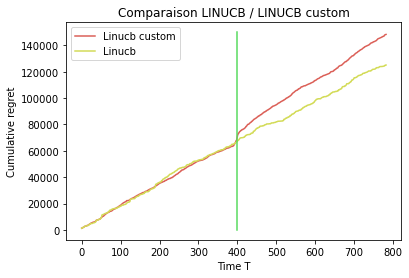

In [39]:
x = [400,400]
y = [0,150000]
cumreg_custom = cumulativeRegret(linucb1[3],rewards)
plt.plot(cumreg_custom,label='Linucb custom');
plt.plot(cum_reg, label='Linucb');
plt.plot(x,y);
plt.xlabel('Time T')
plt.ylabel('Cumulative regret');
plt.title('Comparaison LINUCB / LINUCB custom')
plt.legend();
plt.show();

Les résultats sont sensiblement les mêmes, l'algo custom rattrape les erreurs de jugement de LINUCB "original", mais elles sont trop rares pour que LINUCB_custom soit plus efficace.